In [1]:
import os
import pandas as pd
import numpy as np
import copernicusmarine
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from pandas.plotting import scatter_matrix
import torch
from sklearn.model_selection import train_test_split
sns.set_style("whitegrid")

#to fix the cpu or gpu (if you have cuda change it to 'cuda )
device = torch.device('mps')

Here we use the reduced features (we also take out the feature `year`)

In [2]:
df = pd.read_csv('../datasets_csv/merged_df_049depth.csv')
reduced = [ 'month', 'latitude','longitude', 'spco2',  'fe', 'omega_ca',  'no3'
            , 'dos', 'analysed_sst',  'fgco2','CHL']

df = df[reduced]
X = df.drop(columns='CHL')
y = df['CHL']
# taking out outliers using percentile 
threshold_per =  np.percentile(y, 99)
df_chl_filtered = df[df["CHL"] < threshold_per]

In [3]:
df_chl_filtered

,month,latitude,longitude,spco2,fe,omega_ca,no3,dos,analysed_sst,fgco2,CHL
0,9,50.00,-6.00,350.64914,0.001825,4.230194,0.085536,1025.7375,288.622194,0.227585,1.691628
1,9,50.00,-4.75,369.19666,0.002805,4.163150,0.120819,1025.7048,289.250500,-0.373585,2.985421
2,9,50.00,-4.50,372.18210,0.002507,4.152890,0.085128,1025.6787,289.364500,-0.513694,2.709471
3,9,50.00,-4.25,374.36462,0.002517,4.148163,0.089791,1025.6592,289.463314,-0.595715,1.966574
4,9,50.00,-4.00,376.29180,0.002832,4.120954,0.147231,1025.6259,289.437704,-0.659538,1.774530
...,...,...,...,...,...,...,...,...,...,...,...
426057,12,55.75,6.75,401.20660,0.003070,2.891729,0.747707,1025.5168,281.935013,1.473553,2.462389
426058,12,55.75,7.00,398.89398,0.003361,2.834707,1.204397,1025.4133,281.442690,1.629428,3.094560
426059,12,55.75,7.25,397.25525,0.003699,2.785361,1.786570,1025.3169,280.930626,1.773693,3.464520
426060,12,55.75,7.50,394.90198,0.004049,2.744416,2.345498,1025.2385,280.432226,1.968011,3.270432


Tranforming the dataset to a tensor.

In [4]:
ten = torch.from_numpy(df_chl_filtered.to_numpy()).float()

In [5]:
# here I take a larger test size to see the test loss changes
X_train, X_test, y_train, y_test = train_test_split(ten[:,0:-1],ten[:,-1],test_size= 0.3)

Here we onehot the `'month'` variable. 

In [6]:
day_onehot_train = torch.zeros(X_train.shape[0],12)
day_onehot_train.scatter_(1,X_train[:,0:1].long()-1,1)

day_onehot_test = torch.zeros(X_test.shape[0],12)
day_onehot_test.scatter_(1,X_test[:,0:1].long()-1,1)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Below we scale the X_train and X_test.

In [7]:
X_train_mean = torch.mean(X_train[:,1:], dim=0)
X_train_var = torch.var(X_train[:,1:], dim=0)
X_train = (X_train[:,1:]-X_train_mean)/torch.sqrt(X_train_var)
X_train = torch.cat((X_train, day_onehot_train), dim=1)

X_test = (X_test[:,1:]-X_train_mean)/torch.sqrt(X_train_var)
X_test = torch.cat((X_test, day_onehot_test), dim=1)

# taking all tensors from cpu to mac gpu 'mps'
X_train = X_train.to(device= device)
X_test = X_test.to(device= device)
y_train = y_train.to(device= device).reshape(-1,1)
y_test = y_test.to(device= device).reshape(-1,1)
[X_train.shape,y_train.shape,X_test.shape,y_test.shape]

[torch.Size([295260, 21]),
 torch.Size([295260, 1]),
 torch.Size([126541, 21]),
 torch.Size([126541, 1])]

Defining data loaders both for train and test set.

In [8]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                           shuffle=True)

The model used

In [9]:
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(X_train.shape[1], 512,device= device)),
    ('hidden_activation', nn.ReLU()),
    ('layer2',nn.Linear(512, 256,device= device)),
    ('layer3',nn.ReLU()),
    ('layer4',nn.Linear(256, 128,device= device)),
    ('layer5',nn.ReLU()),
    ('output_linear', nn.Linear(128, 1,device= device))
]))


In [10]:
def make_train_step(model, loss_fn, optimizer):
    # builds & returns the function that will be called inside the loop
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()
    return train_step

In [11]:
model = seq_model

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


n_epochs = 100

# training step
train_step = make_train_step(model, loss_fn, optimizer)
tot_train_loss = []
tot_test_loss = []

for epoch in range(n_epochs):
    training_losses = []
    test_losses = []
    
    for nbatch, (x_batch, y_batch) in enumerate(train_loader):
        #print(nbatch)
        loss = np.sqrt(train_step(x_batch, y_batch))
        training_losses.append(loss)     
    
    for valbatch, (x_val, y_val) in enumerate(test_loader):
        with torch.no_grad():
            model.eval()
            y_that = model(x_val)
            loss_val = torch.sqrt(loss_fn(y_that,y_val))
            test_losses.append(loss_val.item())  
        
    train_loss_avg = np.mean(training_losses)
    test_loss_avg = np.mean(test_losses)
    
    tot_train_loss.append(train_loss_avg )
    tot_test_loss.append( test_loss_avg )
    
    print(f'epoch {epoch+1} | Training loss: {train_loss_avg:.4f} | Test loss: {test_loss_avg:.4f} ')

print(f'Average training loss: {np.mean(tot_train_loss):.4f} | Average test loss: {np.mean(tot_test_loss):.4f} ')          

epoch 1 | Training loss: 0.5515 | Test loss: 0.5058 
epoch 2 | Training loss: 0.4949 | Test loss: 0.4802 
epoch 3 | Training loss: 0.4783 | Test loss: 0.5004 
epoch 4 | Training loss: 0.4679 | Test loss: 0.4615 
epoch 5 | Training loss: 0.4607 | Test loss: 0.4492 
epoch 6 | Training loss: 0.4543 | Test loss: 0.4623 
epoch 7 | Training loss: 0.4496 | Test loss: 0.4517 
epoch 8 | Training loss: 0.4446 | Test loss: 0.4380 
epoch 9 | Training loss: 0.4407 | Test loss: 0.4856 
epoch 10 | Training loss: 0.4376 | Test loss: 0.4372 
epoch 11 | Training loss: 0.4341 | Test loss: 0.5103 
epoch 12 | Training loss: 0.4318 | Test loss: 0.4319 
epoch 13 | Training loss: 0.4285 | Test loss: 0.4197 
epoch 14 | Training loss: 0.4262 | Test loss: 0.4262 
epoch 15 | Training loss: 0.4239 | Test loss: 0.4234 
epoch 16 | Training loss: 0.4212 | Test loss: 0.4384 
epoch 17 | Training loss: 0.4192 | Test loss: 0.4315 
epoch 18 | Training loss: 0.4169 | Test loss: 0.4251 
epoch 19 | Training loss: 0.4156 | Te

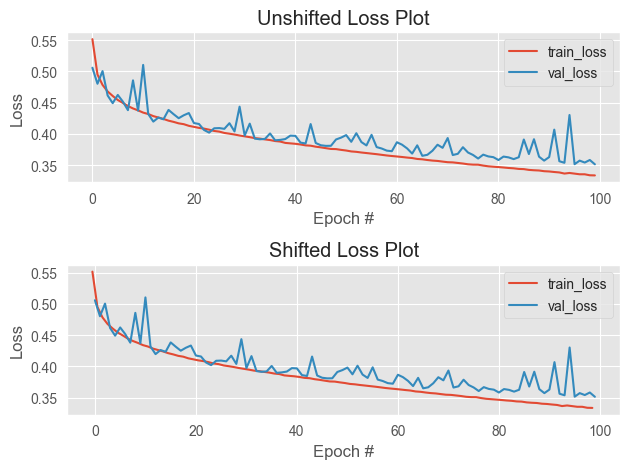

In [13]:
# Plots of training and test loss (trying to understand why validation loss is lower than training at the beginning)
# From the discussion https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/
# load the training history

H = pd.DataFrame(data= {'loss':tot_train_loss, 'val_loss':tot_test_loss})
# determine the total number of epochs used for training, then
# initialize the figure
n_epochs = np.arange(0, len(H["loss"]))
plt.style.use("ggplot")
(fig, axs) = plt.subplots(2, 1)
# plot the *unshifted* training and validation loss
plt.style.use("ggplot")
axs[0].plot(n_epochs, H["loss"], label="train_loss")
axs[0].plot(n_epochs, H["val_loss"], label="val_loss")
axs[0].set_title("Unshifted Loss Plot")
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")
axs[0].legend()
# plot the *shifted* training and validation loss
axs[1].plot(n_epochs - 0.5, H["loss"], label="train_loss")
axs[1].plot(n_epochs, H["val_loss"], label="val_loss")
axs[1].set_title("Shifted Loss Plot")
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Loss")
axs[1].legend()
# show the plots
plt.tight_layout()
plt.show()
